# **YOLO OBJECT DETECTION ASSESSMENT**

Tasks :
- The dataset given consists of images of `live` and `spoof` data.
- You may use any open-source YOLO repositories to complete this assessment.
- Please try to complete section by section.
- There are 2 types of assessment to be completed:
  - Code
  - Explanation  

Note:
- This assessment should be completed in **_3 days_**. Please manage your time accordingly.
- Ensure that **ALL** code blocks has been executed, including training, evaluation, benchmark and visualizations upon submission.
- Add comments to your codes. 


Reference :
- https://pyimagesearch.com/2022/06/20/training-the-yolov5-object-detector-on-a-custom-dataset/
- https://github.com/ultralytics/ultralytics


7 sections to be completed :
- A) PREPROCESSING
- B) VISUALIZE PREPROCESSED DATA
- C) TRAINING
- D) FINDINGS AND CONCLUSION
- E) EVALUATE ON TEST SETS
- F) SUMMARIZE AND IMPROVEMENTS
- G) BONUS POINTS

## A) PREPROCESSING
- Dataset Distribution:
  - Train: 120
  - Validation: 20
  - Test: 20
<!-- you are given datasets : 120 for train , 20 for val , 20 for test -->
- Annotation text file is given in the following format:
  - class_index, x-center, y-center, w , h

Task(s):
- Resize image size
- Recalculate resized images' coordinates:
  - x-center_resized, y-center_resized, w_resized , h_resized
- All the results should be in thier respective folder(s):
    - images/train , images/val, image/test
    - labels/train , labels/val, labels/test
    - *HINT: different YOLO versions/ repositories may have different directory format*

### Create and activate python environment with conda
1. Create a virtual environment named 'yolo-env'
    conda create --name wiseai-object-detect python=3.12 -y
    conda activate wiseai-object-detect

2. Install dependencies from requirements.txt
    pip install -r requirements.txt

In [2]:
'''
These flags control the workflow: 
- set prepare=True to run preprocessing steps
- set train_model=True to train the model
'''
prepare=False #run preprocessing (resizing, cropping, etc.)
train_model=False #train the model

In [3]:
'''
This code block sets up all key file and directory paths for dataset splits, processed data, 
and model outputs using configuration values loaded from config.yaml, ensuring consistent and 
organized access throughout the object detection pipeline.
'''
# Set file paths and import necessary modules, config.yaml for configuration of file paths, benchmarking, and model settings.
from src.utils import *
datasets_path, processed_data_path, models_path, predict_path, model_name, data_class, prepare_benchmark, model_benchmark, params= get_config('config.yaml')

datasets_images_path = datasets_path / "images"
datasets_labels_path = datasets_path / "labels"

train_path = datasets_images_path / "train"
test_path = datasets_images_path / "test"
val_path = datasets_images_path / "val"

output_processed_dataset_path = processed_data_path / prepare_benchmark
output_images_dir = output_processed_dataset_path / "images"
output_labels_dir = output_processed_dataset_path / "labels"

processed_train_path= output_images_dir / "train"
processed_train_labels_path= output_labels_dir / "train"

image_stats_path = datasets_path/"image_statistics.json"
log_path = output_processed_dataset_path / "log.json"
data_yaml_path = output_processed_dataset_path / "data.yaml"

model_name=f"{model_name}-{prepare_benchmark}-{model_benchmark}"
trained_model_path = models_path / model_name


In [4]:
'''
Count the number of images in each split (train, test, validation)

Output: {
    "Train Images": 80,
    "Test Images": 20,
    "Validation Images": 20
}

Comment: The outputs of total number of train images is different from the Session A desciption (80~120).
'''
import json

# Recalculate stats
if not image_stats_path.exists():
    train_count, train_avg_size, train_extremes = count_and_average_image_size(train_path)
    test_count, test_avg_size, test_extremes = count_and_average_image_size(test_path)
    val_count, val_avg_size, val_extremes = count_and_average_image_size(val_path) if val_path.exists() else (0, (0, 0), (0, 0, 0, 0))

    image_stats = {
        "train": {
            "total": train_count,
            "avg_size_WxH": train_avg_size,
            "MinW_MinH_MaxW_MaxH": train_extremes
        },
        "val": {
            "total": val_count,
            "avg_size_WxH": val_avg_size,
            "MinW_MinH_MaxW_MaxH": val_extremes
        },
        "test": {
            "total": test_count,
            "avg_size_WxH": test_avg_size,
            "MinW_MinH_MaxW_MaxH": test_extremes
        }
    }

    with open(image_stats_path, "w") as f:
        json.dump(image_stats, f, indent=4)

    # Display path for confirmation
    print(f"Image statistics saved to: {image_stats_path}")
    print(json.dumps(image_stats, indent=4))

In [5]:
import os
from datetime import datetime

# Desired target size
if prepare:
    target_size = (params['target_size'], params['target_size'])  # (width, height)

    # Set the base paths

    os.makedirs(output_processed_dataset_path, exist_ok=True)
    os.makedirs(output_images_dir, exist_ok=True)
    os.makedirs(output_labels_dir, exist_ok=True)

    # Make sure output directories exist
    for split in ["train", "val", "test"]:
        (output_images_dir / split).mkdir(parents=True, exist_ok=True)
        (output_labels_dir / split).mkdir(parents=True, exist_ok=True)

    # Resize and update label coordinates
    # Apply to all splits
    for split in ["train", "val", "test"]:
        image_files = list((datasets_images_path / split).glob("*.*"))
        for img_file in image_files:
            label_file = datasets_labels_path / split / (img_file.stem + ".txt")
            out_img_file = output_images_dir / split / img_file.name
            out_label_file = output_labels_dir / split / (img_file.stem + ".txt")

            resize_and_adjust_labels(target_size,img_file, label_file, out_img_file, out_label_file)

    log_data = {
        "timestamp": datetime.now().isoformat(),
        "preprocessing": {
            "target_size": target_size
        }
    }

    # Save to JSON
    with open(log_path, "w") as f:
        json.dump(log_data, f, indent=4)

    log_path.resolve()

## B) VISUALIZE PREPROCESSED DATA
- draw bounding box on any 10 images from task A to verify processed datasets and coordinates

In [6]:
%matplotlib inline

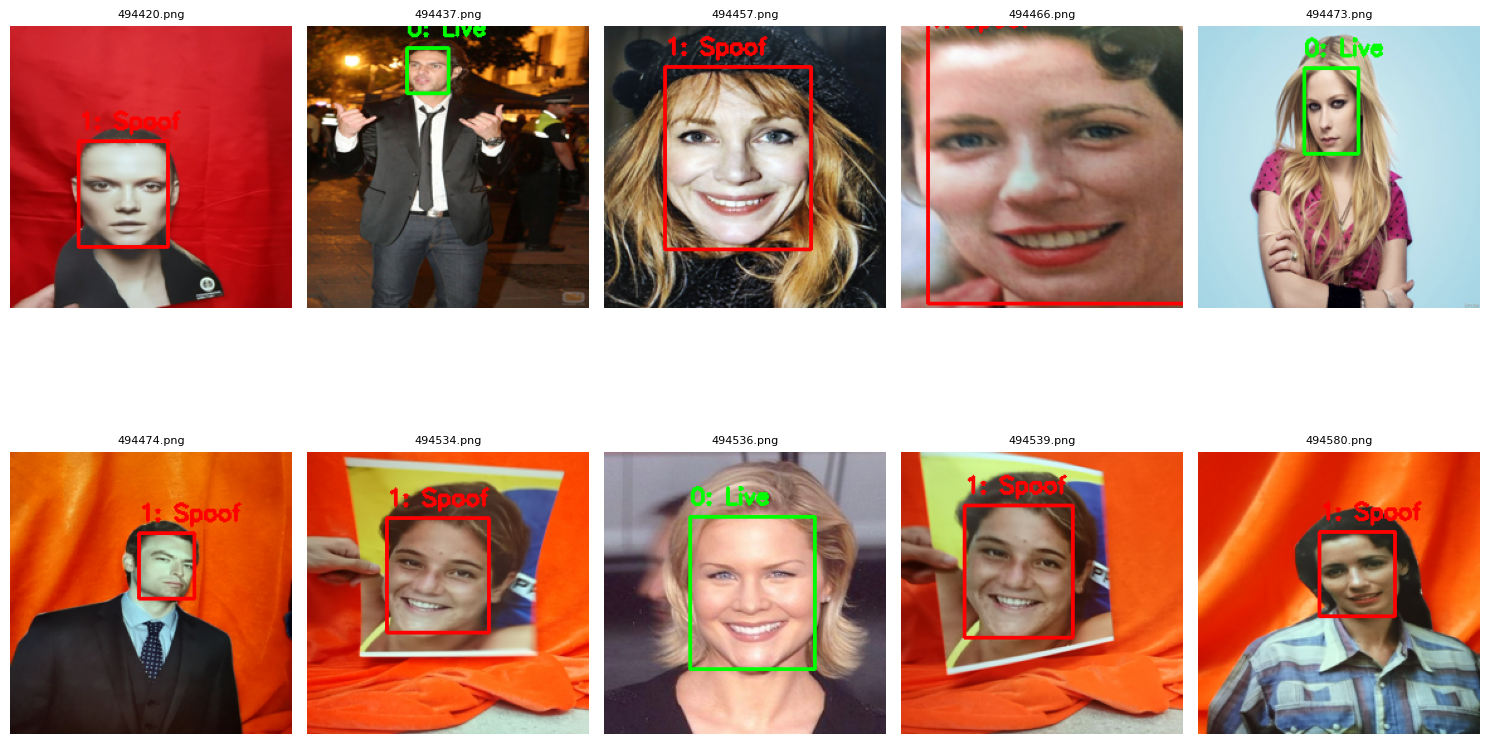

In [7]:
'''
Shown bounding boxes on the first 10 images in the training set with class labels.
Verify that the bounding boxes are correctly drawn and labeled with respected class names.
{Class0: Live, Class1: Spoof}
'''
# Collect up to 10 images for visualization
image_files = list(processed_train_path.glob("*.png"))[:10]
show_grid_images(image_files, processed_train_labels_path, 2, 5)

## C) TRAINING

- Please include your training parameters. (screenshot/ in written form)
<!-- pls include your configuration written here all screenshot of your parameters setup and etc -->
- Specify your output directory path.
  - Model
  - Plots
  - Images (if you have any)

*Hints : according to yolo, you need to have the following files:*
  - hyp yaml file
  - dataset yaml file
  - model yaml file

In [8]:
#Check if GPU is available
!nvidia-smi

Mon Jun 23 01:29:11 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 572.83                 Driver Version: 572.83         CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4050 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   52C    P8              1W /  139W |     155MiB /   6141MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [9]:
#https://www.youtube.com/watch?v=nATRPPZ5dGE for installation of pytorch with cuda support
!pip install ultralytics
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

Looking in indexes: https://download.pytorch.org/whl/cu121


In [10]:
from ultralytics import YOLO
if train_model==True:
    create_data_yaml(train_path="images/train",
                 val_path="images/val", 
                 test_path="images/test",
                 class_names=["live", "spoof"],
                 save_path=data_yaml_path)
    data_yaml_path.resolve()

    model = YOLO("yolo11n.pt")
    model.train(data=data_yaml_path, epochs=params['epochs'], imgsz=params['target_size'], batch=params['batch_size'], device=0, project=models_path, name=model_name, workers=0)

    trained_results_split(
    trained_model_path,
    trained_model_path / "plots",
    trained_model_path / "images"
    )


## D) FINDINGS
- Please state your findings on:
  - Benchmark
  - Performance
  - Visualization

#### 1. Benchmark
- **Model:** YOLOv11s 
- **Image Size:** 224 × 224  
- **Epochs:** 30  
- **Batch Size:** 16
- **Classes:**  
  - 0: live  
  - 1: spoof  
- **Input Format:** RGB images, labels normalized (YOLO format)  
- **Device:** GPU (CUDA-enabled)

---

#### 2. Training Performance
- **mAP@0.5:** 0.976 — Excellent detection accuracy  
- **Precision:** ~0.85
- **Recall:** ~0.9 

##### 2.1 Training Results  
<img src="outputs/models/Spoof-Detect-1-1/plots/results.png" width="800"/>

- Steady reduction in all loss components.
- Continuous improvement in mAP, precision, and recall — strong convergence.

---

#### 3. Validation Performance
- **F1-Score:**  
  - Overall: 0.93 at confidence threshold 0.536

##### 3.1 Confusion Matrix  
<img src="outputs/models/Spoof-Detect-1-1/plots/confusion_matrix.png" width="600"/>

- High accuracy for both classes; minor misclassification between live and spoof.
- A few wrong prediction on non-object images for live.

---

##### 3.2 F1-Confidence Curve  
<img src="outputs/models/Spoof-Detect-1-1/plots/F1_curve.png" width="600"/>

- F1 remains high (>0.8) across most confidence levels.  
- Best performance at threshold ~0.536.

---

##### 3.3 Precision-Recall Curve  
<img src="outputs/models/Spoof-Detect-1-1/plots/PR_curve.png" width="600"/>

- PR curves are steep and ideal, indicating strong class separability.  
- mAP confirms excellent model quality.

---


#### 4. Visualize on Validation Set

Below are the ground truth labels and predicted results on a batch from the validation set. This visualization helps assess the model’s ability to distinguish between 'live' and 'spoof' faces.

**1. Ground Truth Labels**  
<img src="outputs\models\Spoof-Detect-1-1\images\val_batch0_labels.jpg" width="700"/>

**2. Model Predictions with Confidence Scores**  
<img src="outputs\models\Spoof-Detect-1-1\images\val_batch0_pred.jpg" width="700"/>

### Validation Results:
1. Both a `live` and a `spoof` bounding box appear **overlapping**
- The model being **uncertain** and predicting multiple classes for a single face region.
- **False positives**: The model wrongly classifies a spoof image as live (or vice versa) with high confidence.
- The presence of **artifacts** (e.g. paper texture, background clutter) that confuse the model into thinking both classes are present.

2. This kind of overlap highlights areas where the model's **class confidence separation** can be improved—possibly by:
- Increasing the training dataset size or diversity,
- Improving label quality,
- Adjusting non-maximum suppression (**NMS**) thresholds,
- Adding post-processing to remove low-confidence or conflicting detections.



## E) EVALUATION
- test sets can be found at `data/raw/datasets/test`

WARNING 'save_hybrid' is deprecated and will be removed in in the future.

image 1/20 c:\Users\User\Desktop\Job Application\assignment1\wiseai-object-detect\data\processed\1\images\test\494647.png: 224x224 1 spoof, 8.4ms
image 2/20 c:\Users\User\Desktop\Job Application\assignment1\wiseai-object-detect\data\processed\1\images\test\494903.png: 224x224 1 live, 8.8ms
image 3/20 c:\Users\User\Desktop\Job Application\assignment1\wiseai-object-detect\data\processed\1\images\test\495026.png: 224x224 1 live, 9.0ms
image 4/20 c:\Users\User\Desktop\Job Application\assignment1\wiseai-object-detect\data\processed\1\images\test\495343.png: 224x224 2 lives, 8.2ms
image 5/20 c:\Users\User\Desktop\Job Application\assignment1\wiseai-object-detect\data\processed\1\images\test\495414.png: 224x224 1 spoof, 10.0ms
image 6/20 c:\Users\User\Desktop\Job Application\assignment1\wiseai-object-detect\data\processed\1\images\test\495450.png: 224x224 1 spoof, 8.7ms
image 7/20 c:\Users\User\Desktop\Job Application\a

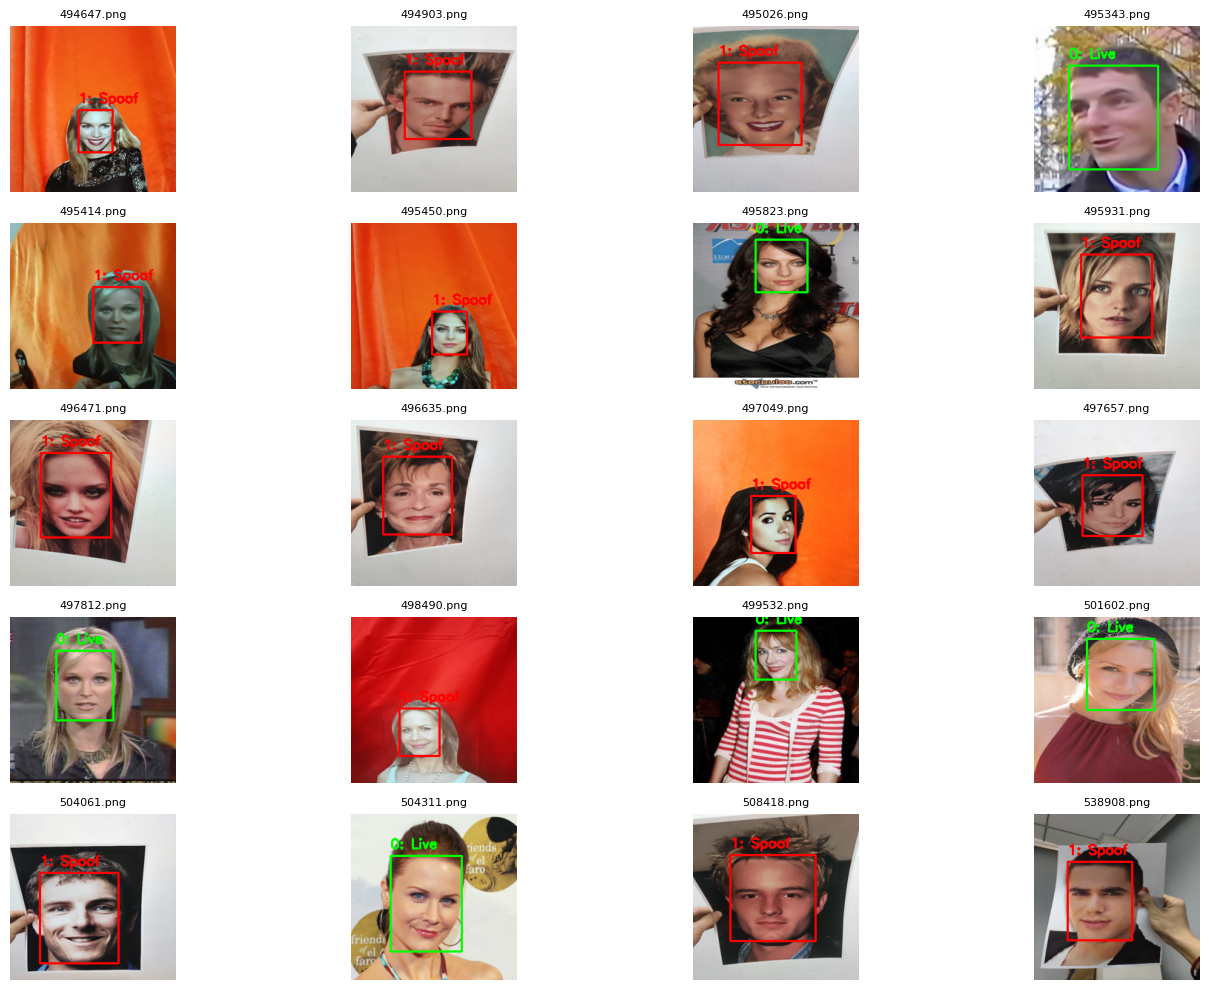

Predicted: 



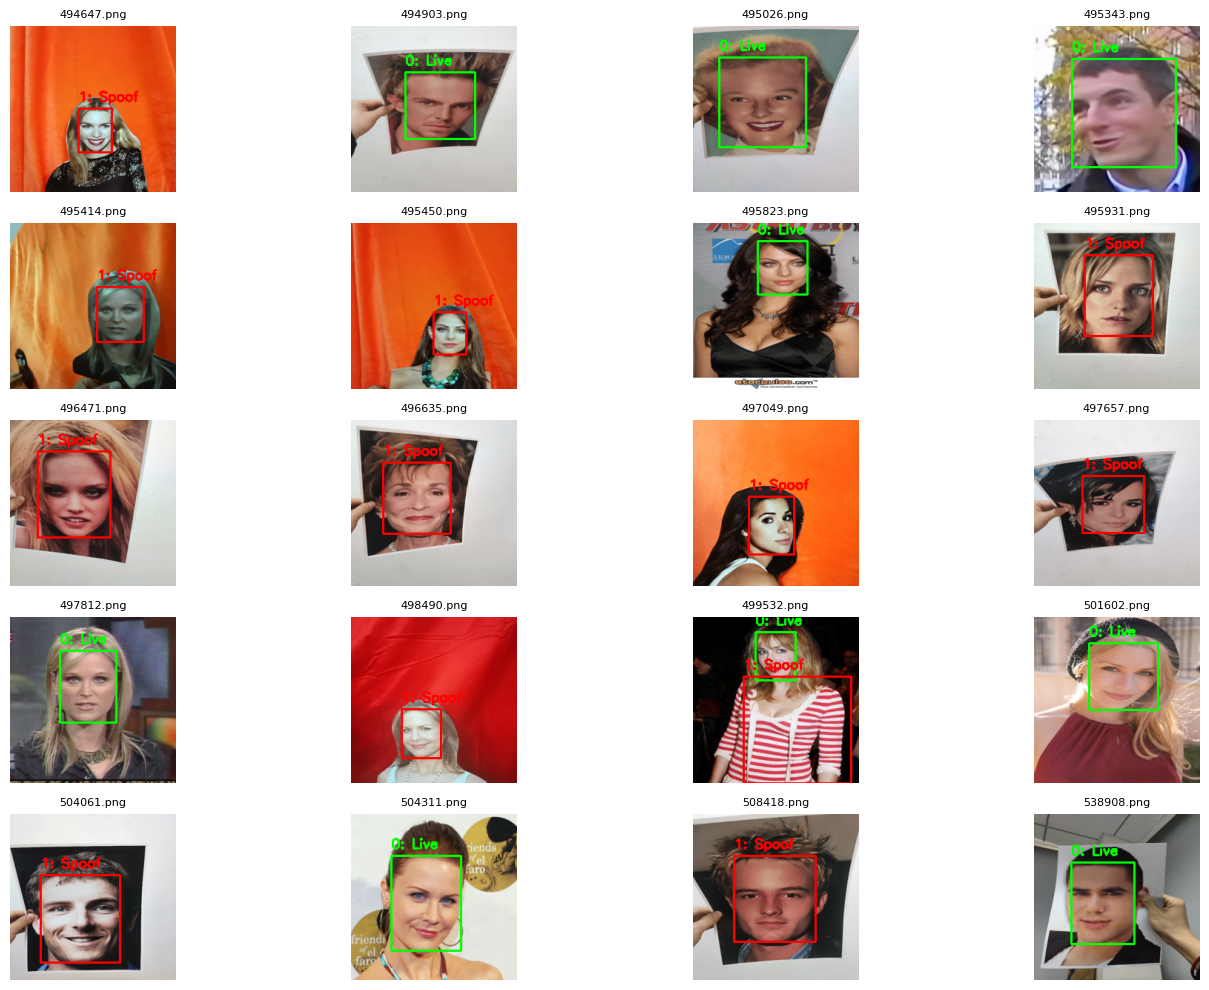

In [11]:
'''
This code loads the trained YOLO model, collects test images
displays a grid comparison of ground truth and predicted bounding boxes
'''
from ultralytics import YOLO
model = YOLO(str(trained_model_path/'weights/best.pt'))  # Adjust path as needed

model.predict(
    source= str(output_images_dir/"test"),  # path to test/val images
    project=predict_path,
    name=model_name,
    conf=params['conf'],      # set your threshold
    iou=params['iou'],        # set your IoU threshold
    agnostic_nms=True,
    save=True,            # ⬅️ Save images with predicted bounding boxes
    save_txt=True, 
    save_json=True,  # Save metrics to JSON
    save_conf=True,  # Save confidence scores
    save_hybrid=True,  # Save hybrid metrics    exist_ok=True              # don't overwrite if already exists
)

# Get all .jpg images from prediction folder
test_images_dir = output_images_dir / "test"
test_image_paths = list(test_images_dir.glob('*.png'))
gt_dir = output_labels_dir / "test"

predicted_image_dir = predict_path / model_name 
predicted_label_dir = predicted_image_dir / "labels"

n_rows, n_cols = 4, 5

# Grid size
# ===== Plot =====
print(f"Ground truth: \n")
show_grid_images(test_image_paths, gt_dir, 5, 4)
print(f"Predicted: \n")
show_grid_images(test_image_paths, predicted_label_dir, 5, 4)

### Inference Results:
1. **Qualitative Observations:**

- Overall Accuracy: The model generally performs well, accurately detecting and classifying faces as "live" or "spoof".
- Misclassifications:
    - Two "spoof" image (495343.png, 495931.png) was incorrectly predicted as "live".
    - Two "live" images (495414.png, 496471.png) were incorrectly predicted as "spoof".
- Missing/Extra Detections: The model successfully detected a bounding box for every face present in the ground truth, and there were no apparent spurious detections (false positives) where no face existed.

2. **Summary and Future Works:**

- The model demonstrates strong overall performance on this inference batch, accurately classifying a significant majority of "live" and "spoof" instances with robust detection capabilities
- Future efforts should focus on analyzing the characteristics of these misclassified images (e.g., 495343.png, 495931.png, 495414.png, 496471.png) to identify common features or challenges. This analysis can inform targeted data augmentation strategies or further model fine-tuning to enhance the discriminative power between "live" and "spoof" categories, particularly for challenging samples.

## F) CONCLUSION AND IMPROVEMENTS

- The model achieved a 0.976 mAP@0.5 and an F1-score of 0.93 at 0.536 confidence on the validation data. 
- The consistent decrease in losses and high precision and recall values demonstrate excellent training convergence and generalization. 
- The confusion matrix confirms the model's high accuracy in distinguishing between "live" and "spoof" detections, with minimal inter-class misclassifications.

## G) BONUS POINTS
- Further improve model accuracy
- Further improve model size and inference speed
- Model conversion (to ONNX / TFLite)
- Model serving (FastAPI / Streamlit)
- Dockerization
- Etc.


> Note: You shall provide proof of your improvements.


In [14]:
pwd

'c:\\Users\\User\\Desktop\\Job Application\\assignment1\\wiseai-object-detect'

In [ ]:
import shutil
from pathlib import Path

# Assuming these paths are correctly defined earlier in your script
# For example:
timestamp = int(datetime.now().timestamp())

src_path = Path(trained_model_path) / "weights" / "best.pt"
dst_path = Path("deploy_models") / f"spoof-detect_v1.1_{timestamp}.pt"
cloud_model_path = Path("deploy_models/cloud-deploy_spoof-detect/app/model") / "best.pt"


# Ensure the parent directory for the destination exists
dst_path.parent.mkdir(parents=True, exist_ok=True)
cloud_model_path.parent.mkdir(parents=True, exist_ok=True) # Ensure cloud destination dir exists

# Copy file using shutil.copyfile()
shutil.copyfile(str(src_path), str(dst_path))
print(f"Model copied to: {dst_path}")

# If you also want to copy to a 'cloud' path, do it separately
shutil.copyfile(str(src_path), str(cloud_model_path))
print(f"Model copied to: {cloud_model_path}")

Model copied to: deploy_models\spoof-detect_v1.1_1750604360.pt
Model copied to: deploy_models\cloud-deploy_spoof-detect\app\model\best.pt


In [ ]:
# Export the model to ONNX and TFLite formats
model.export(format="onnx")  
model.export(format="tflite") 

### A.1 Deploying locally with python environment (W/O GUI)
[Refference](https://github.com/EdjeElectronics/Train-and-Deploy-YOLO-Models)

1. Create python env:

        conda create --name yolo-env1 python=3.12 -y

        conda activate yolo-env1
   
2. Install requirements:
   
        pip install ultralytics
   
    Install Nvidia GPU-enabled version of PyTorch by issuing the following command:

        pip install --upgrade torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
   
3. Locate the file: ```cd wiseai-object-detect```
4. Utilize utils file created by Evan Juras, EJ Technology Consultants. [yolo_detect.py]
    - Add ```save_predict``` function. Function for saving predicted images with bbox.

5. Detect objects for video:

    `python src/yolo_detect.py --model "deploy_models\spoof-detect_v1.1_1750604360.pt" --source "data\processed\1\images\test" --conf 0.5 --iou 0.8 --save_predict`

### A.2 Deploying locally with streamlit (With GUI)

1. Locate the file: ```cd wiseai-object-detect\deploy_models\streamlit_spoof-detect```
2. Create python env:

        conda create --name yolo-env1 python=3.12 -y

        conda activate yolo-env1
   
3. Install requirements:
   
        pip install -r requirements.txt
   
    Install Nvidia GPU-enabled version of PyTorch by issuing the following command:

        pip install --upgrade torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

4. Run streamlit app:
        streamlit run app.py
    
5. GUI guide (`http://localhost:8501`)
    - Select model version
    - Set `conf` , Minimum confidence threshold for displaying detected objects
    - Set `iou` , Minimum IoU threshold for displaying detected objects, if **iou > 0** NMS will be applied',
    - Upload image 
    - Visualise predicted image

### B. Cross-device compatibility (FastAPI-Docker-Render)
1. Browse `https://cloud-deploy-spoof-detect.onrender.com/docs`
2. Click `Try it out`
3. Upload image 
4. Click `Execute`

<img src="assets/cloud-demo.png" width="600"/>

- Preprocess Time: 293.0 ms
- Inference Time: 52,403.8 ms (≈ 52.4 seconds)
- Postprocess Time: 396.2 ms
- Total Time: ~53.1 seconds